In [6]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import os

In [7]:
class DataGen(tf.keras.utils.Sequence):
    def __init__(self, image_files, image_dir, target, batch_size):
        self.image_dir = image_dir
        self.image_files = image_files

        self.target = target
        self.batch_size = batch_size
    def __len__(self):
        return (len(self.image_files) // self.batch_size)-1
    
    def __getitem__(self, idx):
        # Its purpose is to just create batch and then go silent till u need another batch
        # To reserve memory
        batch_files = self.image_files[idx*self.batch_size:(idx+1)*self.batch_size] # Get the batch of files
        images = []
        landmarks = []
        for file in batch_files:
            
            img_path = os.path.join(self.image_dir, file) # The image path by joining the image name
            # This method integrates well with tensorflow, automattically converts images to RGB, 
            # returns a PIL image object, and that makes it easier to convert to numpy
            img = tf.keras.utils.load_img(img_path, target_size=(128, 128)) 
            # Convert the image to numpy array, See? easy, I used to struggle with that
            img_array = tf.keras.utils.img_to_array(img)
            
            # Filling the image list
            images.append(img_array)

            # Normalize bounding box coordinates
            lm = self.target.loc[file].values
            landmarks.append(lm)

        return np.array(images), np.array(landmarks)


In [8]:
def sclae_bbox(boxes, images_size):
    boxes /= images_size

# lm stands for landmarks
lm_data = pd.read_csv('D:/Industry/Projects/Datasets/celeba/Anno/list_landmarks_align_celeba.txt', delim_whitespace=True, skiprows=1)

images_dir = 'D:/Industry/Projects/Datasets/celeba/images/'

In [9]:
# preprocessing landmarks
for col in lm_data.columns:
    if col[-1]=='x':
        lm_data[col] /= 178
    elif col[-1]=='y':
        lm_data[col] /= 218

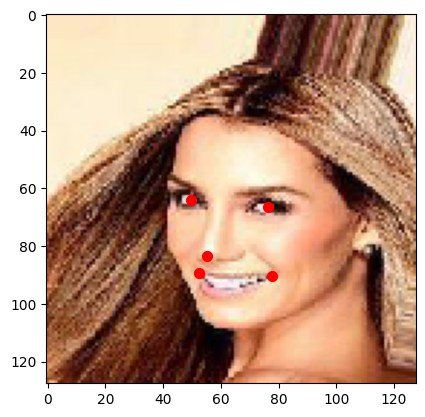

In [10]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

image = tf.keras.utils.load_img(images_dir+'/000001.jpg', target_size=(128, 128)) 
lm = lm_data.iloc[0]
# draw landmarks
fig, ax = plt.subplots()
ax.imshow(image)

# Plot landmarks
for i in range(0, len(lm), 2):
    ax.scatter(lm[i]*128, lm[i+1]*128, s=50, color='red')

In [11]:
from tensorflow.keras import layers as nn

class CNN_LM:
    def __init__(self,input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        self.model = self.build_model()

    def build_model(self):
        model = tf.keras.models.Sequential()
        model.add(nn.InputLayer(input_shape=self.input_shape))
        model.add(nn.Conv2D(32, (3, 3), activation='relu'))
        model.add(nn.MaxPooling2D((2, 2)))
        model.add(nn.Conv2D(64, (3, 3), activation='relu'))
        model.add(nn.MaxPooling2D((2, 2)))
        model.add(nn.Conv2D(128, (3, 3), activation='relu'))
        model.add(nn.MaxPooling2D((2, 2)))
        model.add(nn.Flatten())
        model.add(nn.Dense(512, activation='relu'))
        model.add(nn.Dense(self.num_classes))  
        return model
    def compile_model(self, optimizer='adam', loss='mean_squared_error', metrics=['mse']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)


In [12]:
from sklearn.model_selection import train_test_split
image_files = os.listdir(images_dir)
# splitting data
train_data, val_data = train_test_split(image_files, test_size=0.2, random_state = 42)

In [13]:
batch_size = 32
train_generator = DataGen(train_data, images_dir, lm_data, batch_size)
val_generator = DataGen(val_data, images_dir, lm_data, batch_size)


cnn_model = CNN_LM((128,128,3), 10)

# Compile the model (if you want to do it later)
cnn_model.compile_model()

In [14]:
train_generator = DataGen(train_data, images_dir, lm_data, batch_size)
print(train_generator[len(train_generator)][0].shape)
print(train_generator[len(train_generator)][1].shape)

(32, 128, 128, 3)
(32, 10)


In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard

# 1. ModelCheckpoint: Save the best model based on validation loss
checkpoint_cb = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

# 2. EarlyStopping: Stop training early if validation loss does not improve
early_stopping_cb = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

# 3. TensorBoard: Log training progress for visualization
tensorboard_cb = TensorBoard(log_dir='logs', histogram_freq=1)

callbacks = [checkpoint_cb, early_stopping_cb, tensorboard_cb]

In [16]:
history = cnn_model.model.fit(train_generator,
                    validation_data=val_generator, 
                    epochs=10,
                    callbacks=callbacks,
                    batch_size=32)

Epoch 1/10
5063/5063 [==============================] - ETA: 0s - loss: 58.2066 - mse: 58.2066
Epoch 1: val_loss improved from inf to 0.00272, saving model to best_model.h5
5063/5063 [==============================] - 9260s 2s/step - loss: 58.2066 - mse: 58.2066 - val_loss: 0.0027 - val_mse: 0.0027
Epoch 2/10
5063/5063 [==============================] - ETA: 0s - loss: 0.0015 - mse: 0.0015
Epoch 2: val_loss improved from 0.00272 to 0.00014, saving model to best_model.h5
5063/5063 [==============================] - 8381s 2s/step - loss: 0.0015 - mse: 0.0015 - val_loss: 1.4238e-04 - val_mse: 1.4238e-04
Epoch 3/10
5063/5063 [==============================] - ETA: 0s - loss: 2.2518e-04 - mse: 2.2518e-04
Epoch 3: val_loss did not improve from 0.00014
5063/5063 [==============================] - 7005s 1s/step - loss: 2.2518e-04 - mse: 2.2518e-04 - val_loss: 2.8368e-04 - val_mse: 2.8368e-04
Epoch 4/10
5062/5063 [============================>.] - ETA: 0s - loss: 2.8496e-04 - mse: 2.8496e-04
Ep


KeyboardInterrupt



In [92]:
def plot_prediction(image,landmark, prediction):
    
    plt.imshow(image)
    # Plot landmarks
    for i in range(0, len(landmark), 2):
        plt.scatter(landmark[i]*128, landmark[i+1]*128, s=50, color='red', alpha = 0.5, label = f"Landmark {landmark.keys()[i][:-2]}")
    # Plot predictions
    for i in range(0, len(landmark), 2):
        plt.scatter(prediction[0][i]*128, prediction[0][i+1]*128, s=50, color='green', label = f"Prediction {landmark.keys()[i][:-2]}")


In [65]:
from tensorflow.keras.utils import load_img, img_to_array
def image_predictor(model,image_dir,image_name):
    image = load_img(image_dir+image_name, target_size=(128, 128))
    image = img_to_array(image)
    image_array = np.expand_dims(image, axis=0)
    prediction = model.predict(image_array)
    return image, prediction

1/1 [==============================] - 0s 17ms/step


Ellipsis

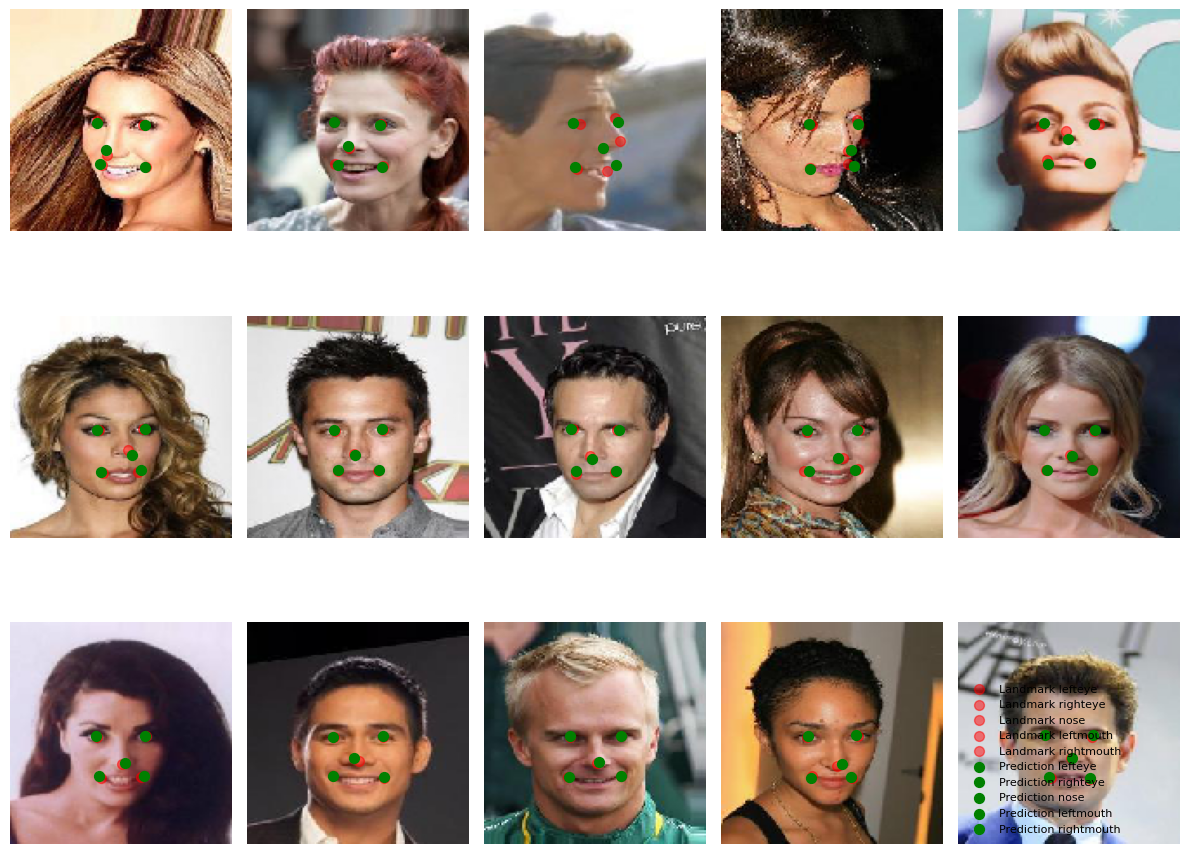

In [93]:
from tensorflow.keras.models import load_model


# Load the best model
best_model = load_model("best_model.h5")
fig, axes = plt.subplots(3, 5, figsize=(12, 10))
axes = axes.flatten()

for i in range(15):
    image_name = lm_data.index[i]
    image, prediction = image_predictor(best_model,images_dir,image_name)
    landmark = lm_data.loc[image_name]
    plt.sca(axes[i])  # Set current axis to the subplot
    plot_prediction(image/255, landmark, prediction)
    axes[i].axis("off")
plt.tight_layout()
plt.legend(fontsize=8, loc='lower left', frameon=False)
...